In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
import wrds
from pandas.tseries.offsets import MonthEnd
from fredapi import Fred

plt.style.use('seaborn')

In [9]:
##############################################################################
'''Function to calculate Distance-to-default

Replication of dtd in R -> https://rdrr.io/rforge/ifrogs/src/R/dtd.R
Extra documentation -> https://rdrr.io/rforge/ifrogs/f/inst/doc/dtd.pdf

#Data can be retrieve directly from CRSP and COMPUSTAT for US firms

Requires subscription to WRDS with access to CRSP and COMPUSTAT, 
and create/have a free account with St Louis Fed FRED API 
(https://fred.stlouisfed.org/docs/api/fred/) 

ALL YOU NEED TO INPUT IS THE FOLLOWING:
    1.  List of permno codes
    2.  Start date
    3.  End date
'''
##############################################################################

'Function to calculate Distance-to-default\n\nReplication of dtd in R -> https://rdrr.io/rforge/ifrogs/src/R/dtd.R\nExtra documentation -> https://rdrr.io/rforge/ifrogs/f/inst/doc/dtd.pdf\n\n#Data can be retrieve directly from CRSP and COMPUSTAT for US firms\n\nRequires subscription to WRDS with access to CRSP and COMPUSTAT, \nand create/have a free account with St Louis Fed FRED API \n(https://fred.stlouisfed.org/docs/api/fred/) \n\nALL YOU NEED TO INPUT IS THE FOLLOW:\n    1.  List of permno codes\n    2.  Start date\n    3.  End date\n'

In [10]:
conn=wrds.Connection() #connect to WRDS API
fred = Fred(api_key='') #enter api key when account created with St Louis FRED

Enter your WRDS username [lockiemichalski]:lock96
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [11]:
####EXAMPLE COMPANIES####
#american airlines -> cusip = 02376R102, permno = 21020
#disney -> cusip = 254687106, permno = 26403
#procter & gamble co -> cusip = 742718109, permno = 18163
#coca-cola -> cusip = 191098102, permno = 11995
#exxon mobil -> cusip = 30231G102, permno = 11850
#abbott laboratories -> cusip = 002824100, permno = 20482
#chevron -> cusip = 166764100, permno = 14541
#united parcel service -> cusip = 911312106, permno = 87447
#mcdonalds corp -> cusip = 580135101, permno = 43449

In [12]:
unique_permno = ['21020', '26403', '18163','66181','65875','11995','11850',
                 '20482','14541','87447','43449'] #list of permno codes to use to retrieve model inputs
placeholders_permno = ','.join('%s' for i in range(len(unique_permno))) # '?,?'

start_date = '12/31/1995'
end_month = '12/31/2020'

In [13]:
#Function to retrieve the inputs required for the Merton model to estimate dtd
def distance_to_default_inputs(start_date, end_month, placeholders_permno):
    #Calculate market value using CRSP
    crsp ='''
    SELECT DISTINCT date, permno, cusip, (abs(prc)*shrout)/1000 as mcap_crsp_dd, ret,
    abs(prc) as price_unadj, (abs(prc)/CFACPR) as price_adj, shrout
    FROM crsp.dsf
    WHERE date between '{}' and '{}'
    and permno IN ({})'''.format(start_date, end_month, placeholders_permno)
    crsp_query = conn.raw_sql(crsp, params=(unique_permno))
    crsp_query = crsp_query.sort_values(by=['cusip', 'date']).reset_index(drop=True)
    crsp_query['date'] = pd.to_datetime(crsp_query['date'])
    crsp_query['Country'] = 'US'
    
    '''Risk free-rate = 1-Year Treasury Constant Maturity Rate (DGS1)'''
    fred_call = {'trate_1y_dd':'DGS1'}
    
    #Function to retrieve data from dictionary and output in dataframe
    fred_df = pd.DataFrame()
    for key, value in fred_call.items():
        data_fred = fred.get_series(value)
        fred_df[key] = data_fred
    fred_df = fred_df.reset_index()
    fred_df.rename(columns={'index':'date'},inplace=True)
    fred_df.iloc[:,1:] = (fred_df.iloc[:,1:].fillna(method='ffill', limit=2)).round(4)
    fred_df['Country'] = 'US'
    fred_df['date'] = pd.to_datetime(fred_df['date'])
    fred_df['trate_1y_dd']/=100
    crsp_query = crsp_query.merge(fred_df, how='left', on=['Country','date'])
    
    'Prior 12 month rolling sd following Vassalou and Zing (2004) - The Journal of Finance'
    crsp_query['sd_12M_dd'] = crsp_query.groupby('permno')['ret'].apply(lambda x : x.rolling(252).std()*(252**0.5))
    
    '''Following convention in the literature on the Merton model (Crosbie and Bohn (2003),
     Vassalou and Xing (2004) and, Campbell, Hilscher, and Szilagyi (2008)), we use T = 1
     and use short-term plus one half long-term book debt to proxy for the face value 
     of debt BD. This convention is a simple way to take account of the fact that 
     long-term debt may not mature until after the horizon of the distance to 
     default calculation. '''
    crsp_query['t_dd'] = 1
    
    '''OBTAIN short-term debt (current liabilites are COMPUSTAT #45 = dlcq), and 
    long-term book debt (COMPUSTAT #51 = dlttq)'''
    
    '''GET GVKEY for CRSP/COMPUSTAT link'''
    ccm = '''
    select gvkey, lpermno as PERMNO, linktype, linkprim, 
    linkdt, linkenddt
    from crsp.ccmxpf_linktable
    where (linktype ='LU' or linktype='LC')
    and (linkprim = 'P' or linkprim = 'C')
    and lpermno IN ({})'''.format(placeholders_permno)
    ccm_query = conn.raw_sql(ccm, params=(unique_permno))
    ccm_query = ccm_query.drop_duplicates(subset='gvkey')
    
    unique_gvkey = list(ccm_query['gvkey'].dropna().unique().astype(str))
    placeholders_gvkey = ','.join('%s' for i in range(len(unique_gvkey)))  # '?,?'
    
    #Fundamentals compustat quarterly
    comp = '''
    SELECT gvkey, cusip, datadate as date, fyr, fyearq, fqtr, dlcq, dlttq, conm
    FROM comp.fundq
    WHERE indfmt IN ('INDL','FS')
    and datafmt='STD' 
    and popsrc='D'
    and consol='C' 
    and datadate between '{}' and '{}' 
    and gvkey IN ({})'''.format(start_date, end_month, placeholders_gvkey)
    compustat_query = conn.raw_sql(comp, params=(unique_gvkey))
    compustat_query = compustat_query.sort_values(by=['gvkey', 'date']).reset_index(drop=True)
    compustat_query['date'] = pd.to_datetime(compustat_query['date'])    
    compustat_query['half_dlttq'] = 0.5*compustat_query['dlttq']
    compustat_query['bv_debt_dd'] = (compustat_query[['dlcq','half_dlttq']].sum(axis=1))
    compustat_query['bv_debt_dd']  = compustat_query.groupby('gvkey')['bv_debt_dd'].shift(1)
    
    ccm_query = ccm_query[['gvkey','permno']]
    compustat_query = compustat_query.merge(ccm_query, how='left', on='gvkey')
    
    crsp_query['date'] = crsp_query['date'] + MonthEnd(0)
    crsp_query = crsp_query.drop_duplicates(['permno','date'],keep='last')
    
    compustat_query = compustat_query.merge(crsp_query[['date','permno','mcap_crsp_dd',
                                                        'sd_12M_dd','trate_1y_dd','t_dd']], how='left', on=['date', 'permno'])

    compustat_query = compustat_query[['date','conm','gvkey','cusip','mcap_crsp_dd','bv_debt_dd','sd_12M_dd','trate_1y_dd']]

    return compustat_query

In [14]:
#Run the function and obtain the vars here
df = distance_to_default_inputs(start_date, end_month, placeholders_permno)

In [15]:
df.head()

,date,conm,gvkey,cusip,mcap_crsp_dd,bv_debt_dd,sd_12M_dd,trate_1y_dd
0,1995-12-31,AMERICAN AIRLINES GROUP INC,001045,02376R102,NaN,NaN,NaN,NaN
1,1996-03-31,AMERICAN AIRLINES GROUP INC,001045,02376R102,6833.504000,3876.0,NaN,0.0541
2,1996-06-30,AMERICAN AIRLINES GROUP INC,001045,02376R102,8216.299000,3654.0,NaN,0.0570
3,1996-09-30,AMERICAN AIRLINES GROUP INC,001045,02376R102,7240.699375,3007.5,NaN,0.0571
4,1996-12-31,AMERICAN AIRLINES GROUP INC,001045,02376R102,8013.646875,2980.0,0.279343,0.0551


In [16]:
#Estimate distance to default - returns dtd, asset value, and asset volatility 
#Will take around 1 min to run with the 9 example companies

#ASSUMPTION MADE HERE - > If firm has no debt, replace bv_debt with 0.01
df.loc[(df.bv_debt_dd == 0),'bv_debt_dd']= 0.01
df.loc[(df.bv_debt_dd.isnull()),'bv_debt_dd']= 0.01                     
df = df.dropna(subset=['sd_12M_dd']).reset_index(drop=True) #drop prior 12 month rows for sd calc

df_output = pd.DataFrame(np.zeros((df.shape[0], 7))) #df with desired shape and columns
df_output.columns = ['date','conm','gvkey','cusip','dtd','asset_value_a','volatility_a']

#row-wise loop to estimate unknown vars (asset value and volatility) and distance to default
for idx, row in enumerate(range(0,len(df))):
    df_row = df.loc[row] #row to estimate dtd
    mcap = df_row[4] #market cap of equity (CRSP vars = abs(PRC) x SHROUT)
    debt = df_row[5] #book value of debt
    vol = df_row[6] #12 month rolling volatility of asset returns
    r = df_row[7] #1-year treasury rate

    if debt == 0:
        'Please provide a non-zero debt value'
    elif (type(mcap) or type(debt) or type(vol) or type(r)) != np.float64:
        'Please ensure inputs are floats'

    T=1 #maturity of 1 year
    V = mcap + debt #starting value of market value of equity    
    sV = (mcap * vol) / debt #starting value of asset volatility of equity   
    debt = debt * np.exp(-r) #present value of debt

    #Solving reverse Black-Scholes for market value of asset and asset volatility  
    def d1(V, debt, sV, T):
        num = (np.log(V/debt)) + ((0.5*sV**2)*T) #num = (np.log(V/debt)) + ((r_f + 0.5*sV**2)*T)
        den = sV * np.sqrt(T)    
        return num/den

    def d2(V, debt, sV, T):
        d2 = d1(V, debt, sV, T) - sV*np.sqrt(T)
        return d2

    unknown_vars = [V,sV] #vars to find that minimize the objective function
    known_vars = [mcap,debt,vol,T] #observed vars

    def objective_function(unknown_vars,known_vars):
        mcap, debt, vol, T = known_vars
        V,sV = unknown_vars
        rho=1
        e1 = -mcap + V*norm.cdf(d1(V,debt*rho,sV,T)) - rho*debt*norm.cdf(d2(V,rho*debt,sV,T))
        e2 = -vol*mcap + sV*V*norm.cdf(d1(V,debt*rho,sV,T))
        obj_fun = (e1*e1) + (e2*e2)
        return obj_fun

    #Solve for asset value and asset volatility - estimated from the market value 
    #and volatility of equity, and the book value of liabilities. Minimize the error term
    bnds = ((known_vars[0], np.inf), (0,np.inf)) #V (sV) lb is mcap (0), up is infinity for both 
    optimize_obj_function = minimize(fun=objective_function, 
                                     x0=unknown_vars,
                                     args=(known_vars),
                                     method='L-BFGS-B', 
                                     bounds=bnds)

    Va, sigma_a = optimize_obj_function.x #save the V and sV values

    # Distance-to-default calculation
    dtd = (Va - debt)/(Va*sigma_a)

    #append date,gvkey,cusip,dtd,Va, and sigma_a to df to output
    df_output.loc[idx] = [df_row[0],df_row[1],df_row[2],df_row[3],dtd,Va,sigma_a]


<ipython-input-16-162f05346831>:33: RuntimeWarning: divide by zero encountered in double_scalars
  return num/den


In [17]:
df_output.head()

,date,conm,gvkey,cusip,dtd,asset_value_a,volatility_a
0,1996-12-31 00:00:00,AMERICAN AIRLINES GROUP INC,001045,02376R102,3.579823,10833.890594,0.206626
1,1997-03-31 00:00:00,AMERICAN AIRLINES GROUP INC,001045,02376R102,3.762082,10165.142759,0.196255
2,1997-06-30 00:00:00,AMERICAN AIRLINES GROUP INC,001045,02376R102,3.458886,10926.039637,0.223217
3,1997-09-30 00:00:00,AMERICAN AIRLINES GROUP INC,001045,02376R102,3.643810,12671.345438,0.220407
4,1997-12-31 00:00:00,AMERICAN AIRLINES GROUP INC,001045,02376R102,3.437349,14257.005221,0.239061


In [18]:
df_output.tail()

,date,conm,gvkey,cusip,dtd,asset_value_a,volatility_a
1034,2019-12-31 00:00:00,UNITED PARCEL SERVICE INC,010920,911312106,4.128040,96363.165994,0.206215
1035,2020-03-31 00:00:00,UNITED PARCEL SERVICE INC,010920,911312106,2.937537,81624.276731,0.273545
1036,2020-06-30 00:00:00,UNITED PARCEL SERVICE INC,010920,911312106,2.696639,96530.010968,0.300737
1037,2020-09-30 00:00:00,UNITED PARCEL SERVICE INC,010920,911312106,2.529621,134914.385912,0.345230
1038,2020-12-31 00:00:00,UNITED PARCEL SERVICE INC,010920,911312106,2.423089,136273.200111,0.364754


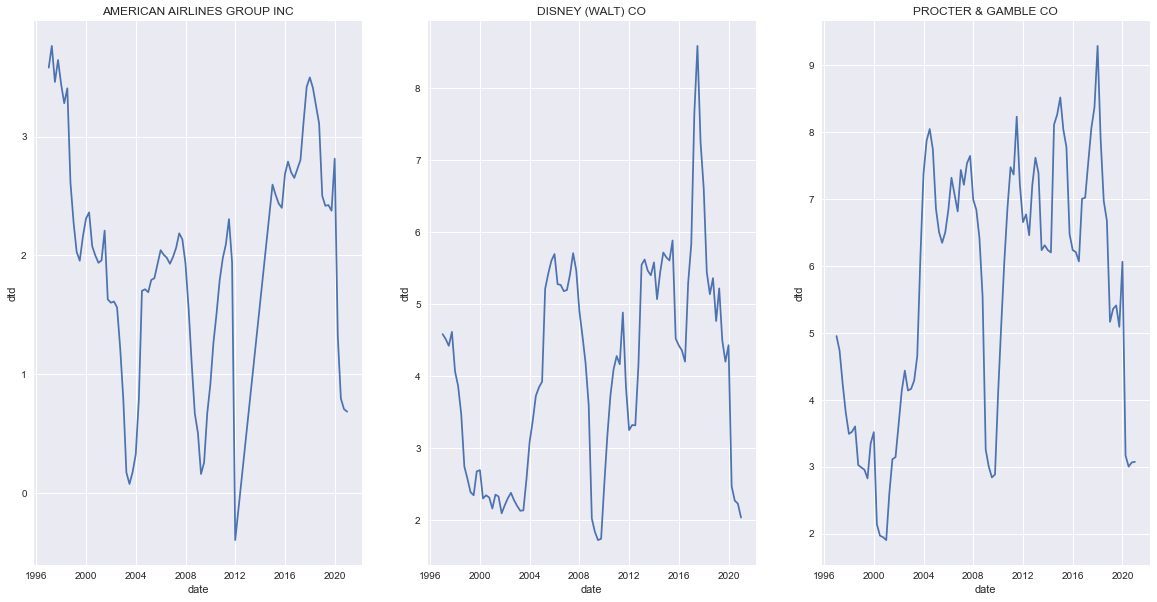

In [19]:
cusips1=['02376R102','254687106','742718109']
fig, ax = plt.subplots(1,3, figsize=(20, 10))
for cusip, subplot in zip(cusips1, ax.flatten()):
    data = df_output[df_output['cusip']==cusip]
    p = sns.lineplot(data=data, x='date',y='dtd',ax=subplot)
    p.set(title = data['conm'].iloc[0])

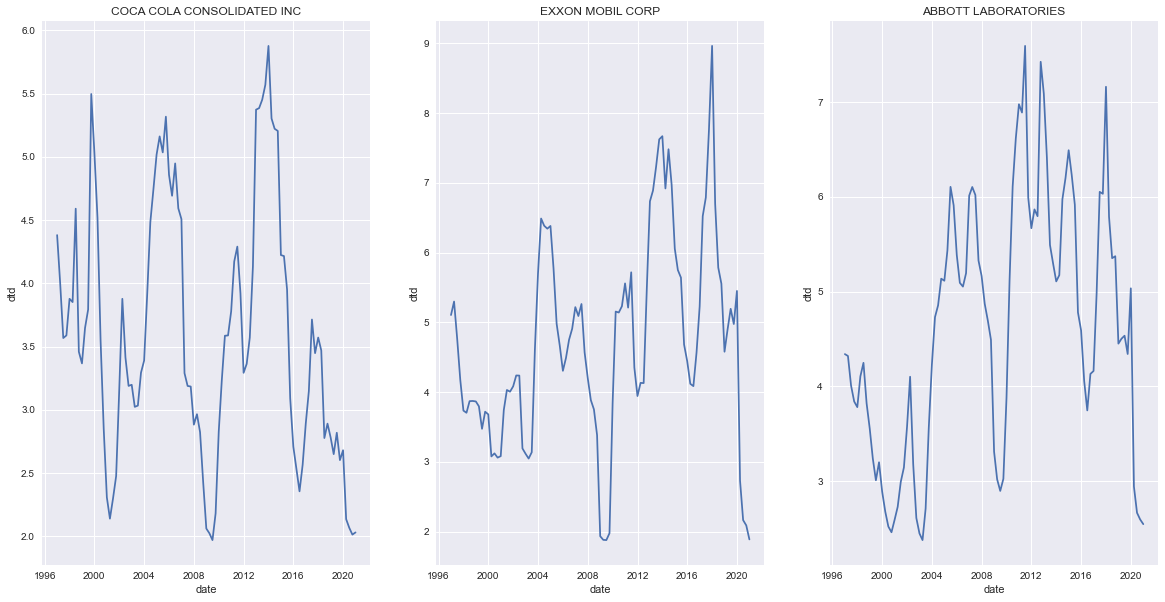

In [20]:
cusips2=['191098102','30231G102','002824100']
fig, ax = plt.subplots(1,3, figsize=(20, 10))
for cusip, subplot in zip(cusips2, ax.flatten()):
    data = df_output[df_output['cusip']==cusip]
    p = sns.lineplot(data=data, x='date',y='dtd',ax=subplot)
    p.set(title = data['conm'].iloc[0])

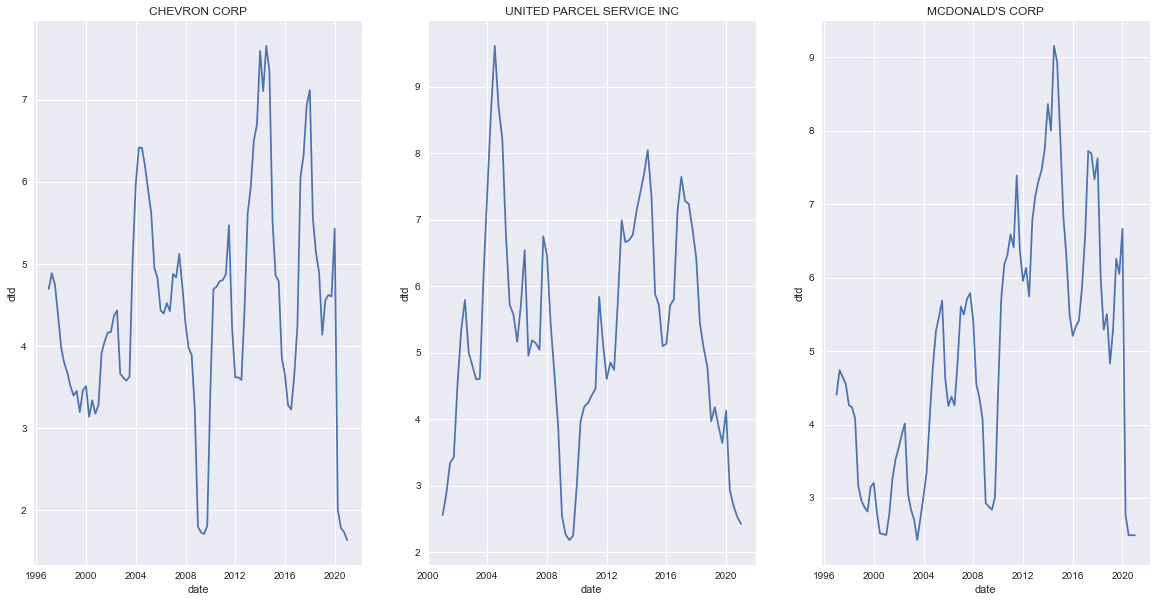

In [21]:
cusips3=['166764100','911312106','580135101']
fig, ax = plt.subplots(1,3, figsize=(20, 10))
for cusip, subplot in zip(cusips3, ax.flatten()):
    data = df_output[df_output['cusip']==cusip]
    p = sns.lineplot(data=data, x='date',y='dtd',ax=subplot)
    p.set(title = data['conm'].iloc[0])